In [ ]:
# Purpose: Install required Python packages for TTM and data downloads (uncomment to run)
#! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"
#! pip install gdown

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.22) to c:\users\colle\appdata\local\temp\pip-install-57ceibqr\granite-tsfm_f1eb3ac89db0423099450672a7c5646b
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 216850d0cb073e31689049c1334f701fe11bc2c3
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git 'C:\Users\colle\AppData\Local\Temp\pip-install-57ceibqr\granite-tsfm_f1eb3ac89db0423099450672a7c5646b'
  Running command git checkout -q 216850d0cb073e31689049c1334f701fe11bc2c3


In [ ]:
import math
import os
import numpy as np
import pandas as pd
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Subset
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    ForecastDFDataset,
    TimeSeriesForecastingPipeline,
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
)
from tsfm_public.toolkit.time_series_preprocessor import prepare_data_splits
from tsfm_public.toolkit.util import select_by_timestamp
from tsfm_public.toolkit.visualization import plot_predictions
from tsfm_public.toolkit.lr_finder import optimal_lr_finder

# Config
FORECAST_LENGTH = 28
CONTEXT_LENGTH = 90
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
REVISION = "90-30-ft-l1-r2.1" 
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Purpose: Load the Events-encoded DBS Excel file and normalize the date column
data_path = "Datasets/Events encoded DBS data (2).xlsx"
data = pd.read_excel(data_path)
# Normalize common column names
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
elif 'date' in data.columns:
    data['Date'] = pd.to_datetime(data['date'])
else:
    raise ValueError('No Date column found in DBS file; please ensure there is a Date column')
data = data.sort_values('Date').reset_index(drop=True)
data.head()

c:\Users\colle\anaconda3\envs\granite\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Vol.,Price,Open,High,Low,Change %,vol_clean,Date,Event,Event_Description,Is_Event_Positive,is_event_day,is_event_positive_flag,is_covid_period,regime
0,2.03M,15.06,15.15,15.17,15.02,0.00,2030000.0,2014-01-02,NaN,NaN,NaN,0,0,0,0
1,2.73M,14.96,15.04,15.06,14.86,-0.01,2730000.0,2014-01-03,NaN,NaN,NaN,0,0,0,0
2,2.73M,14.96,15.04,15.06,14.86,-0.01,2730000.0,2014-01-04,NaN,NaN,NaN,0,0,0,0
3,2.73M,14.99,14.96,15.00,14.90,0.00,1370000.0,2014-01-05,NaN,NaN,NaN,0,0,0,0
4,1.37M,14.99,14.96,15.00,14.90,0.00,1370000.0,2014-01-06,NaN,NaN,NaN,0,0,0,0


In [10]:
# Purpose: Choose the forecasting target column and build `column_specifiers` for the preprocessor
# Identify target column (prefer 'Price', fallback to 'Close')
if 'Price' in data.columns:
    target_col = 'Price'
elif 'Close' in data.columns:
    target_col = 'Close'
else:
    # pick a last-named numeric column as a heuristic
    numeric_cols = data.select_dtypes(include=[float, int]).columns.tolist()
    if not numeric_cols:
        raise ValueError('No numeric columns found to use as target')
    target_col = numeric_cols[-1]

# ID / grouping columns (optional). If you have multiple symbols, set symbol_col accordingly
symbol_col = None
if 'Symbol' in data.columns:
    symbol_col = 'Symbol'

# Construct column_specifiers
cols = list(data.columns)
drop_cols = ['Date', target_col] + ([symbol_col] if symbol_col else [])
control_columns = [c for c in cols if c not in drop_cols]
column_specifiers = {
    'timestamp_column': 'Date',
    'id_columns': [symbol_col] if symbol_col else [],
    'target_columns': [target_col],
    'control_columns': control_columns,
    'static_categorical_columns': [symbol_col] if symbol_col else [],
    'categorical_columns': [],
}
column_specifiers

{'timestamp_column': 'Date',
 'id_columns': [],
 'target_columns': ['Price'],
 'control_columns': ['Vol.',
  'Open',
  'High',
  'Low',
  'Change %',
  'vol_clean',
  'Event',
  'Event_Description',
  'Is_Event_Positive',
  'is_event_day',
  'is_event_positive_flag',
  'is_covid_period',
  'regime'],
 'static_categorical_columns': [],
 'categorical_columns': []}

In [11]:
# Purpose: Split data into train/validation/test by date — allow targeting a forecast year (e.g., 2025)
# Set `target_year` to the calendar year you want to forecast. If not present, falls back to 70/15/15 split.
target_year = 2025  # change this to your desired forecast year

unique_dates = np.sort(data['Date'].unique())
years = np.unique(data['Date'].dt.year)

if target_year in years:
    # test = all dates in the target year
    test_dates = np.sort(data.loc[data['Date'].dt.year == target_year, 'Date'].unique())
    # validation = previous calendar year if present, else last 15% block
    valid_year = target_year - 1
    if valid_year in years:
        valid_dates = np.sort(data.loc[data['Date'].dt.year == valid_year, 'Date'].unique())
        # train = everything else (exclude valid+test)
        train_dates = np.setdiff1d(unique_dates, np.concatenate([valid_dates, test_dates]))
    else:
        # fallback: use dates prior to test as train/valid split by 70/15 ratio
        prior_dates = unique_dates[unique_dates < test_dates[0]]
        if len(prior_dates) < 2:
            # not enough prior data — fallback to original split
            n = len(unique_dates)
            train_end = int(n * 0.7)
            valid_end = int(n * 0.85)
            train_dates = unique_dates[:train_end]
            valid_dates = unique_dates[train_end:valid_end]
            test_dates = unique_dates[valid_end:]
        else:
            n = len(prior_dates)
            train_end = int(n * 0.85)
            train_dates = prior_dates[:train_end]
            valid_dates = prior_dates[train_end:]
else:
    # Default 70/15/15 split when target_year is not available
    n = len(unique_dates)
    train_end = int(n * 0.7)
    valid_end = int(n * 0.85)
    train_dates = unique_dates[:train_end]
    valid_dates = unique_dates[train_end:valid_end]
    test_dates = unique_dates[valid_end:]

# Update FORECAST_LENGTH to match test horizon (use number of unique dates in test set)
try:
    FORECAST_LENGTH = int(len(np.unique(test_dates)))
    print(f"Set FORECAST_LENGTH = {FORECAST_LENGTH} based on test set (year={target_year})")
except Exception:
    print("Unable to set FORECAST_LENGTH automatically; keeping existing value.")

# Build splits
train_data = data[data['Date'].isin(train_dates)].copy()
valid_data = data[data['Date'].isin(valid_dates)].copy()
test_data = data[data['Date'].isin(test_dates)].copy()

print('Train / Valid / Test date ranges:')
print(train_dates[[0, -1]] if len(train_dates) else 'empty')
print(valid_dates[[0, -1]] if len(valid_dates) else 'empty')
print(test_dates[[0, -1]] if len(test_dates) else 'empty')
len(train_data), len(valid_data), len(test_data)

Set FORECAST_LENGTH = 603 based on test set (year=2025)
Train / Valid / Test date ranges:
['2014-01-02T00:00:00.000000' '2021-09-12T00:00:00.000000']
['2021-09-13T00:00:00.000000' '2023-05-08T00:00:00.000000']
['2023-05-09T00:00:00.000000' '2024-12-31T00:00:00.000000']


(2824, 610, 609)

In [12]:
# Clean human-formatted numeric strings (e.g., '2.03M', '1.2K', '$3,200') before training the preprocessor
import re
import numpy as np

def _parse_human_number(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return x
    s = str(x).strip()
    # remove common currency symbols and commas
    s = s.replace(',', '').replace('$', '').replace('£', '').replace('€', '')
    # percent
    if s.endswith('%'):
        try:
            return float(s[:-1]) / 100.0
        except Exception:
            return np.nan
    m = re.match(r'^([0-9]*?[0-9]+)*([KkMmBbTt])?$', s)
    if m:
        num = float(m.group(1))
        suf = m.group(2)
        if suf:
            suf = suf.lower()
            mult = {'k': 1e3, 'm': 1e6, 'b': 1e9, 't': 1e12}.get(suf, 1)
            return num * mult
        return num
    try:
        return float(s)
    except Exception:
        return np.nan

# Columns to attempt converting: target + control columns. We convert on the full dataframe `data` so splits remain consistent.
cols_to_try = [target_col] + column_specifiers.get('control_columns', [])
for c in cols_to_try:
    if c in data.columns:
        # apply parser only if column dtype is object or contains strings
        if data[c].dtype == object or data[c].dtype == 'string':
            data[c] = data[c].apply(_parse_human_number)
# Recreate splits after cleaning to ensure consistent dtypes in each split
train_data = data[data['Date'].isin(train_dates)].copy()
valid_data = data[data['Date'].isin(valid_dates)].copy()
test_data = data[data['Date'].isin(test_dates)].copy()

# Build and train the TimeSeriesPreprocessor
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=FORECAST_LENGTH,
    scaling=True,
    encode_categorical=True,
    scaler_type="standard",
)
trained_tsp = tsp.train(train_data)
# Preprocess splits
train_pp = tsp.preprocess(train_data)
valid_pp = tsp.preprocess(valid_data)
test_pp = tsp.preprocess(test_data)
train_pp.head()

c:\Users\colle\anaconda3\envs\granite\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\colle\anaconda3\envs\granite\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\colle\anaconda3\envs\granite\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


,Vol.,Price,Open,High,Low,Change %,vol_clean,Date,Event,Event_Description,Is_Event_Positive,is_event_day,is_event_positive_flag,is_covid_period,regime
0,NaN,-1.023752,-1.001315,-1.021394,-1.009302,-0.011578,-1.060041,2014-01-02,NaN,NaN,NaN,-0.136964,-0.086556,-0.388297,-0.496779
1,NaN,-1.048140,-1.028124,-1.048063,-1.048605,-0.809061,-0.832591,2014-01-03,NaN,NaN,NaN,-0.136964,-0.086556,-0.388297,-0.496779
2,NaN,-1.048140,-1.028124,-1.048063,-1.048605,-0.809061,-0.832591,2014-01-04,NaN,NaN,NaN,-0.136964,-0.086556,-0.388297,-0.496779
3,NaN,-1.040824,-1.047621,-1.062610,-1.038779,-0.011578,-1.274493,2014-01-05,NaN,NaN,NaN,-0.136964,-0.086556,-0.388297,-0.496779
4,NaN,-1.040824,-1.047621,-1.062610,-1.038779,-0.011578,-1.274493,2014-01-06,NaN,NaN,NaN,-0.136964,-0.086556,-0.388297,-0.496779


In [13]:
# Purpose: Build Torch datasets required by the Trainer and pipeline
frequency_token = tsp.get_frequency_token(tsp.freq)
dataset_params = column_specifiers.copy()
dataset_params['frequency_token'] = frequency_token
dataset_params['context_length'] = CONTEXT_LENGTH
dataset_params['prediction_length'] = FORECAST_LENGTH

train_dataset = ForecastDFDataset(train_pp, **dataset_params)
valid_dataset = ForecastDFDataset(valid_pp, **dataset_params)
test_dataset = ForecastDFDataset(test_pp, **dataset_params)
len(train_dataset), len(valid_dataset), len(test_dataset)

(2132, 1, 1)

In [14]:
# Purpose: Load the pretrained TinyTimeMixer and adapt channel indices to our preprocessor
set_seed(1234)
# Ensure prediction_filter_length is valid: must be >0 and < prediction_length
if FORECAST_LENGTH <= 1:
    raise ValueError(f"FORECAST_LENGTH must be > 1 to set a valid prediction_filter_length (got {FORECAST_LENGTH})")
# Choose a reasonable default for the filter length (no larger than 8, and strictly less than FORECAST_LENGTH)
prediction_filter_length = min(8, max(1, FORECAST_LENGTH - 1))
print(f"Using prediction_filter_length={prediction_filter_length} (FORECAST_LENGTH={FORECAST_LENGTH})")

model = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH,
    revision=REVISION,
    context_length=CONTEXT_LENGTH,
    prediction_filter_length=prediction_filter_length,
    num_input_channels=tsp.num_input_channels,
    decoder_mode="mix_channel",
    prediction_channel_indices=tsp.prediction_channel_indices,
    exogenous_channel_indices=tsp.exogenous_channel_indices,
    categorical_vocab_size_list=tsp.categorical_vocab_size_list,
    enable_forecast_channel_mixing=True,
)
print("Model loaded. Number of params:", count_parameters(model))

Using prediction_filter_length=8 (FORECAST_LENGTH=603)


Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

Model loaded. Number of params: 455474


In [15]:
# Purpose: Two-stage training helper — warmup (head only) then full finetune
import math
from transformers import EarlyStoppingCallback


def prepare_trainer(model, train_dataset, valid_dataset, batch_size=32, lr=1e-5, num_epochs=10, freeze_backbone=False):
    """Create a HuggingFace Trainer. If freeze_backbone=True, only head/decoder params remain trainable."""
    if freeze_backbone:
        # keep head and decoder trainable, freeze others
        prefixes = ("head", "decoder")
        for name, p in model.named_parameters():
            p.requires_grad = any(name.startswith(pref) for pref in prefixes)
    else:
        for p in model.parameters():
            p.requires_grad = True

    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    steps_per_epoch = max(1, math.ceil(len(train_dataset) / batch_size))
    scheduler = OneCycleLR(optimizer, lr, epochs=num_epochs, steps_per_epoch=steps_per_epoch)

    args = TrainingArguments(
        output_dir=os.path.join(OUT_DIR, "output_training"),
        overwrite_output_dir=True,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=2 * batch_size,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=2,
        report_to="none",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        optimizers=(optimizer, scheduler),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3), tracking_callback],
    )

    return trainer


def run_training(mode="warmup"):
    """Run a two-stage training routine: 'warmup' or 'finetune'.
    - warmup: freeze backbone, train head/decoder for a few epochs with higher LR
    - finetune: unfreeze all and train with smaller LR
    """
    if mode == "warmup":
        trainer = prepare_trainer(model, train_dataset, valid_dataset, batch_size=64, lr=1e-4, num_epochs=5, freeze_backbone=True)
    elif mode == "finetune":
        trainer = prepare_trainer(model, train_dataset, valid_dataset, batch_size=32, lr=1e-5, num_epochs=10, freeze_backbone=False)
    else:
        raise ValueError("mode must be 'warmup' or 'finetune'")

    print(f"Starting {mode} training...")
    trainer.train()
    print("Evaluation:")
    print(trainer.evaluate())
    trainer.save_model(os.path.join(OUT_DIR, f"finetuned_{mode}"))

# Example usage (uncomment to run):
# run_training('warmup')
# run_training('finetune')

**Training Guidance**
- Use the `run_training('warmup')` helper to train only the head/decoder first (faster, stabilizes new head weights).
- Then run `run_training('finetune')` to unfreeze the whole model and train with a smaller learning rate.
- If training is unstable, reduce batch size, lower LR, or increase `num_train_epochs`.
- Consider increasing `CONTEXT_LENGTH` or adding engineered lags/exogenous controls in `control_columns` if the model lacks relevant signals.

In [ ]:
# Purpose: Run the two-stage training (uncomment to execute).
# WARNING: Training may take time and requires enough GPU/CPU resources.
# Run warmup (head-only) first:
# run_training('warmup')

# After warmup completes, run full finetune:
# run_training('finetune')

# Optional: If you want to run here with custom settings instead of the helper, example:
# trainer = prepare_trainer(model, train_dataset, valid_dataset, batch_size=32, lr=1e-5, num_epochs=15, freeze_backbone=False)
# trainer.train()

Device set to use cpu


Post-finetune metrics:
  MSE : 0.504386
  RMSE: 0.710201
  Pearson R: 0.987571
  R^2: 0.974410


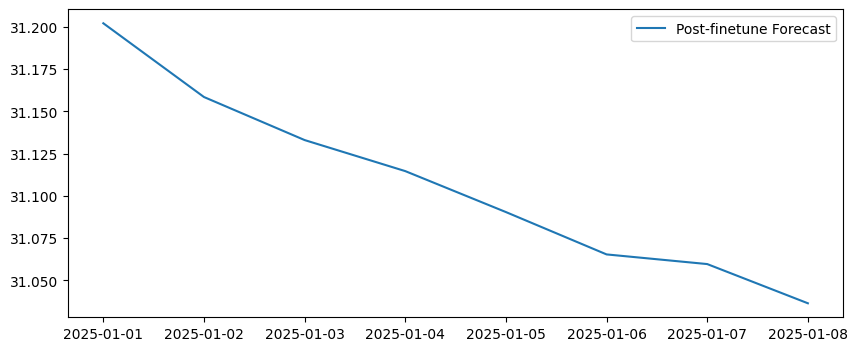

In [31]:
# Purpose: Re-evaluate and show metrics after finetuning (run after training finished)
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Reload best model if training saved it (optional)
# model = TinyTimeMixerForPrediction.from_pretrained(os.path.join(OUT_DIR, 'finetuned_finetune'))

pipeline = TimeSeriesForecastingPipeline(model, device=device, feature_extractor=tsp, batch_size=100)
forecast_df = pipeline(test_data)
# reuse the previous metric computation (aggregate)
a = np.asarray(forecast_df[target_col].tolist())
p = np.asarray(forecast_df[target_col + '_prediction'].tolist())
if a.ndim == 1:
    a = a.reshape(1, -1)
if p.ndim == 1:
    p = p.reshape(1, -1)
min_len = min(a.shape[1], p.shape[1])
a = a[:, :min_len]
p = p[:, :min_len]
valid_mask = ~np.any(np.isnan(a), axis=1)
if valid_mask.sum() == 0:
    print('No valid series to score after removing NaNs')
else:
    a_flat = a[valid_mask].ravel()
    p_flat = p[valid_mask].ravel()
    mse = mean_squared_error(a_flat, p_flat)
    rmse = np.sqrt(mse)
    try:
        r2 = r2_score(a_flat, p_flat)
    except Exception:
        r2 = float('nan')
    try:
        pearson_r = np.corrcoef(a_flat, p_flat)[0,1] if np.std(a_flat) != 0 and np.std(p_flat) != 0 else float('nan')
    except Exception:
        pearson_r = float('nan')
    print('Post-finetune metrics:')
    print(f'  MSE : {mse:.6f}')
    print(f'  RMSE: {rmse:.6f}')
    print(f'  Pearson R: {pearson_r:.6f}')
    print(f'  R^2: {r2:.6f}')

# Display a few example series plots to visually inspect improvements
import matplotlib.pyplot as plt
s = 0
row = forecast_df.iloc[s]
pred = np.asarray(row[target_col + '_prediction']).reshape(-1)
actual = np.asarray(row[target_col]).reshape(-1)

hist = data.sort_values('Date')
last_date = hist['Date'].max()
from pandas.tseries.frequencies import to_offset
freq_str = getattr(tsp, 'freq', pd.infer_freq(data['Date']))
try:
    offset = to_offset(freq_str)
except Exception:
    offset = to_offset('D')
# Use the DateOffset `offset` when building the future date index (avoids invalid Timedelta strings)
future_dates = pd.date_range(start=last_date + offset, periods=len(pred), freq=offset)
plt.figure(figsize=(10,4))
# Plot history
plt.plot(hist['Date'], hist[target_col], label='History')
# Plot forecast
plt.plot(future_dates, pred, label='Post-finetune Forecast')
# Connect last history point to first forecast point
try:
    last_hist_value = hist[target_col].iloc[-1]
    if len(pred) > 0 and not (pd.isna(last_hist_value) or np.isnan(pred[0])):
        plt.plot([last_date, future_dates[0]], [last_hist_value, pred[0]], color='C1', linewidth=2, linestyle='--')
except Exception:
    pass
plt.legend(); plt.show()

c:\Users\colle\anaconda3\envs\granite\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\colle\anaconda3\envs\granite\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\colle\anaconda3\envs\granite\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Extending FORECAST_LENGTH to 90
Using prediction_filter_length= 8


Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

Forecast shapes (actuals, predictions) => (520, 30) (520, 8)


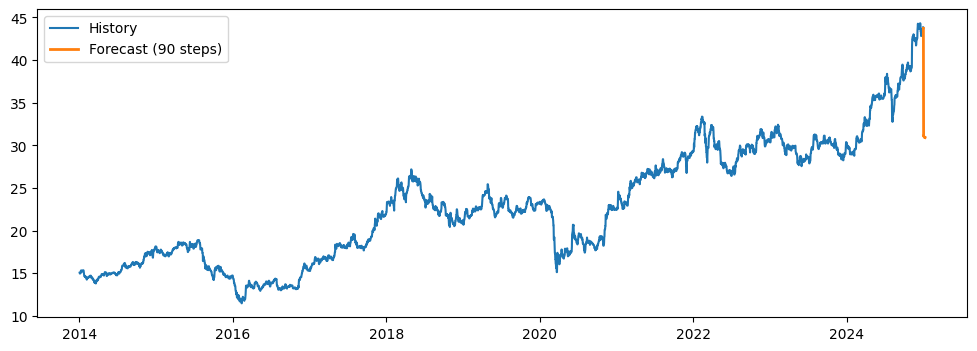

In [32]:
# Purpose: Rebuild preprocessor + model to forecast longer horizons (example: 90 steps)
# WARNING: this retrains the preprocessor and reloads the model with the new prediction length
DESIRED_FORECAST_HORIZON = 90  # adjust as needed
print('Extending FORECAST_LENGTH to', DESIRED_FORECAST_HORIZON)
FORECAST_LENGTH = DESIRED_FORECAST_HORIZON
# Rebuild TimeSeriesPreprocessor with the new prediction length
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=FORECAST_LENGTH,
    scaling=True,
    encode_categorical=True,
    scaler_type='standard',
)
trained_tsp = tsp.train(train_data)
train_pp = tsp.preprocess(train_data)
valid_pp = tsp.preprocess(valid_data)
test_pp = tsp.preprocess(test_data)

# Recreate datasets using the new preprocessor
dataset_params = column_specifiers.copy()
dataset_params['frequency_token'] = tsp.get_frequency_token(tsp.freq)
dataset_params['context_length'] = CONTEXT_LENGTH
dataset_params['prediction_length'] = FORECAST_LENGTH
train_dataset = ForecastDFDataset(train_pp, **dataset_params)
valid_dataset = ForecastDFDataset(valid_pp, **dataset_params)
test_dataset = ForecastDFDataset(test_pp, **dataset_params)

# Reload model with a safe prediction_filter_length for the new horizon
prediction_filter_length = min(8, max(1, FORECAST_LENGTH - 1))
print('Using prediction_filter_length=', prediction_filter_length)
model = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH,
    revision=REVISION,
    context_length=CONTEXT_LENGTH,
    prediction_filter_length=prediction_filter_length,
    num_input_channels=tsp.num_input_channels,
    decoder_mode='mix_channel',
    prediction_channel_indices=tsp.prediction_channel_indices,
    exogenous_channel_indices=tsp.exogenous_channel_indices,
    categorical_vocab_size_list=tsp.categorical_vocab_size_list,
    enable_forecast_channel_mixing=True,
)

# Run pipeline and get extended forecasts
pipeline = TimeSeriesForecastingPipeline(model, device=device, feature_extractor=tsp, batch_size=3)
forecast_df_long = pipeline(test_data)
print('Forecast shapes (actuals, predictions) =>', np.asarray(forecast_df_long[target_col].tolist()).shape, np.asarray(forecast_df_long[target_col + '_prediction'].tolist()).shape)

# Quick plot the first series with the extended horizon
import matplotlib.pyplot as plt
row = forecast_df_long.iloc[0]
pred = np.asarray(row[target_col + '_prediction']).reshape(-1)
hist = data.sort_values('Date')
last_date = hist['Date'].max()
from pandas.tseries.frequencies import to_offset
freq_str = getattr(tsp, 'freq', pd.infer_freq(data['Date']))
try:
    offset = to_offset(freq_str)
except Exception:
    offset = to_offset('D')
future_dates = pd.date_range(start=last_date + offset, periods=len(pred), freq=offset)
plt.figure(figsize=(12,4))
# Plot historical series
plt.plot(hist['Date'], hist[target_col], label='History')
# Plot forecast series
plt.plot(future_dates, pred, label=f'Forecast ({DESIRED_FORECAST_HORIZON} steps)', linewidth=2)
# Draw a small connecting segment between the last history point and first forecast point
try:
    last_hist_value = hist[target_col].iloc[-1]
    if len(pred) > 0 and not (pd.isna(last_hist_value) or np.isnan(pred[0])):
        plt.plot([last_date, future_dates[0]], [last_hist_value, pred[0]], color='C1', linewidth=2)
except Exception:
    pass
plt.legend(); plt.show()

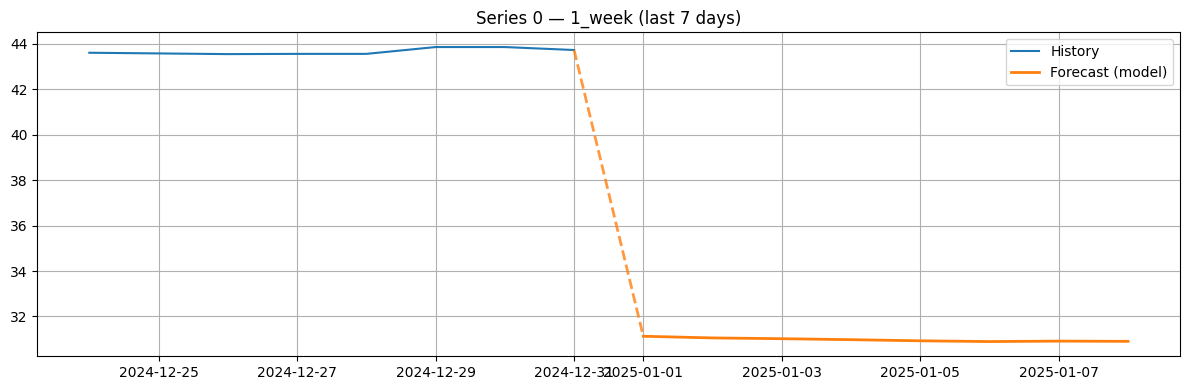

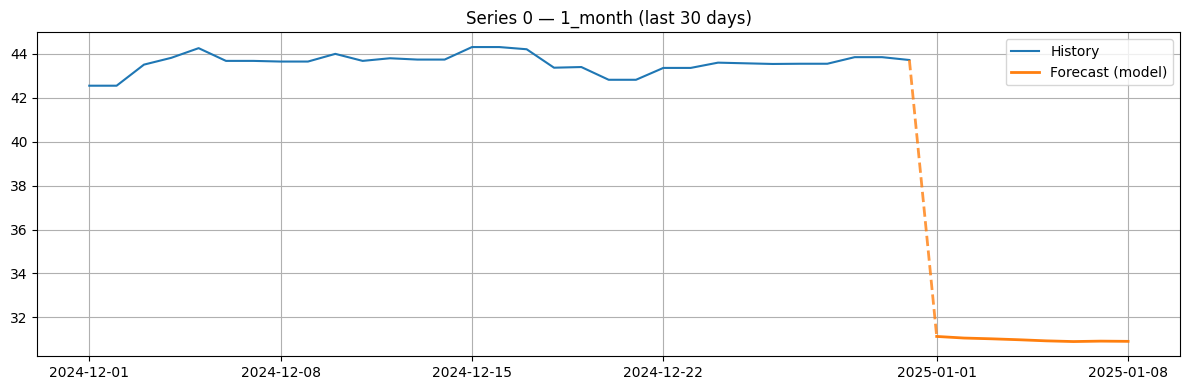

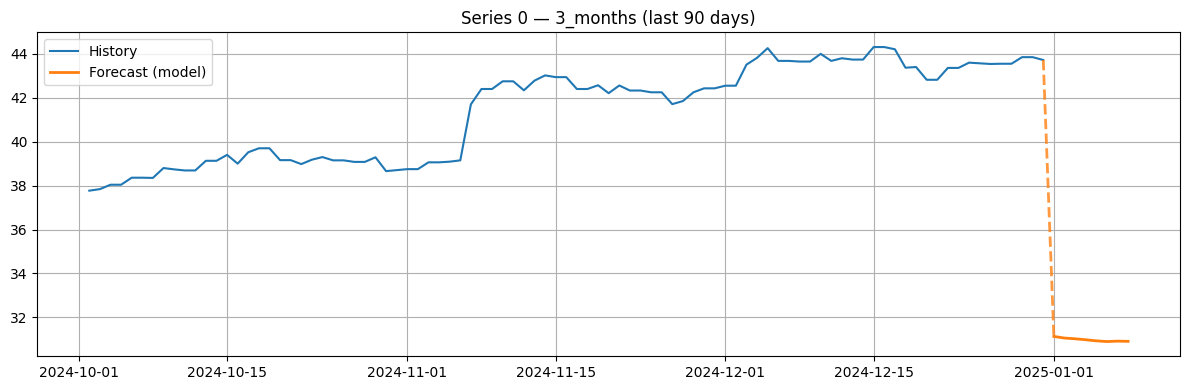

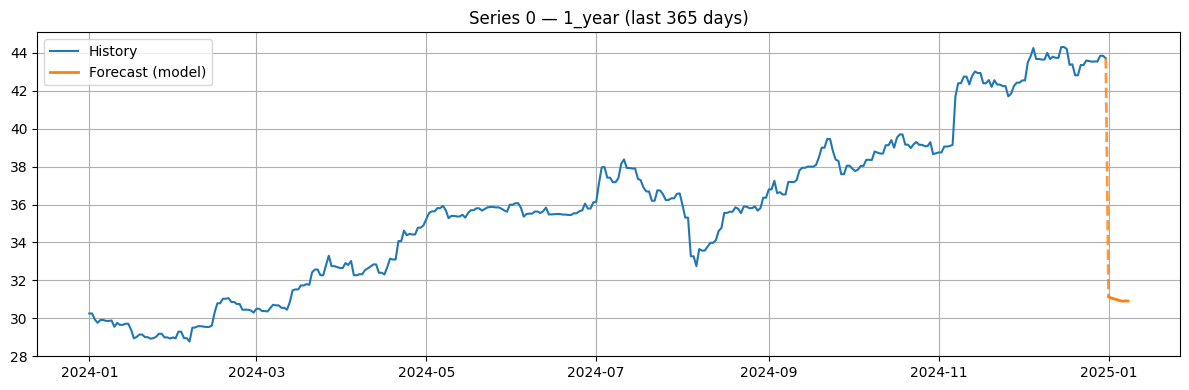

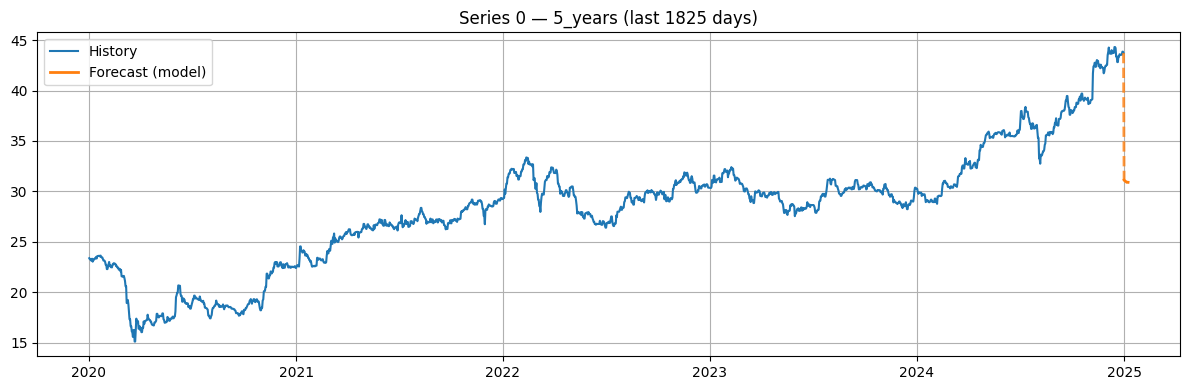

Generated separate figures for windows: ['1_week', '1_month', '3_months', '1_year', '5_years'] with EXTEND_FORECAST_STEPS= 0


In [ ]:
# Purpose: Generate separate figures per lookback window (1w,1m,3m,1y,5y) with up to 6 series each
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tseries.frequencies import to_offset

# Use the long-horizon forecast if available, else fallback to `forecast_df`
df_for_plot = forecast_df_long if 'forecast_df_long' in globals() else (forecast_df if 'forecast_df' in globals() else None)
if df_for_plot is None:
    raise NameError('No forecast dataframe found (forecast_df_long or forecast_df) — run the forecasting cell first')

# Determine frequency offset for future index
freq_candidate = getattr(tsp, 'freq', None) if 'tsp' in globals() else pd.infer_freq(data['Date'])
if not freq_candidate:
    freq_candidate = pd.infer_freq(data['Date'])
try:
    freq_str = freq_candidate if isinstance(freq_candidate, str) else None
    offset = to_offset(freq_str) if freq_str is not None else pd.Timedelta(freq_candidate)
except Exception:
    try:
        offset = to_offset(str(freq_candidate))
    except Exception:
        offset = to_offset('D')

# Lookback windows (label, days)
lookbacks = [
    ('1_week', 7),
    ('1_month', 30),
    ('3_months', 90),
    ('1_year', 365),
    ('5_years', 365 * 5),
]

# Only plot a single representative series (first row) per lookback window
series_index = 0  # change this to plot a different series

# Optionally extend the forecast when plotting (in steps). This only affects the
# visualization: it uses a simple linear extrapolation of the predicted values
# if a longer horizon is requested without re-running the model.
EXTEND_FORECAST_STEPS = 0  # set to 0 to disable extension

def _extend_prediction(pred, steps):
    if steps <= 0:
        return pred
    if len(pred) >= 2:
        # use average recent slope for linear extrapolation
        tail = pred[min(5, len(pred)):]
        slope = np.mean(np.diff(tail))
        extra = pred[1] + slope * np.arange(1, steps + 1)
    else:
        # not enough points — repeat last value
        extra = np.repeat(pred[1] if len(pred) else 0.0, steps)
    return np.concatenate([pred, extra])

for label, days in lookbacks:
    fig, ax = plt.subplots(figsize=(12, 4))
    row = df_for_plot.iloc[series_index]
    pred = row.get(target_col + '_prediction')
    if pred is None:
        ax.text(0.5, 0.5, 'No prediction', ha='center')
        plt.show()
        continue
    pred = np.asarray(pred).reshape(-1)
    # Historical series selection
    if 'Symbol' in df_for_plot.columns and pd.notna(row.get('Symbol')):
        sym = row['Symbol']
        hist = data.loc[data['Symbol'] == sym].sort_values('Date')
        series_label = f'Symbol={sym}'
    else:
        hist = data.sort_values('Date')
        series_label = f'Series {series_index}'
    if hist.empty:
        ax.text(0.5, 0.5, 'No history', ha='center')
        plt.show()
        continue
    last_date = hist['Date'].max()
    # optionally extend the prediction for plotting
    #pred_ext = _extend_prediction(pred, EXTEND_FORECAST_STEPS)
    #future_dates = pd.date_range(start=last_date + offset, periods=len(pred_ext), freq=offset)
    # Slice history window
    start_date = last_date - pd.Timedelta(days=days)
    hist_slice = hist[hist['Date'] >= start_date]
    if target_col in hist_slice.columns:
        ax.plot(hist_slice['Date'], hist_slice[target_col], label='History', color='C0')
    ax.plot(future_dates[:len(pred)], pred, label='Forecast (model)', color='C1', linewidth=2)
    # Connect the last history point to the first forecast point for continuity
    try:
        last_hist_value = hist[target_col].iloc[-1]
        if len(pred) > 0 and not (pd.isna(last_hist_value) or np.isnan(pred[0])):
            ax.plot([last_date, future_dates[0]], [last_hist_value, pred[0]], color='C1', linewidth=2, linestyle='--', alpha=0.8)
    except Exception:
        pass
    if EXTEND_FORECAST_STEPS > 0:
        ax.plot(future_dates[len(pred):], pred_ext[len(pred):], label=f'Extended +{EXTEND_FORECAST_STEPS} steps', color='C2', linestyle='--')
    ax.set_title(f'{series_label} — {label} (last {days} days)')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

print('Generated separate figures for windows:', [lb[0] for lb in lookbacks], 'with EXTEND_FORECAST_STEPS=', EXTEND_FORECAST_STEPS)